
Creating a testable alloy space.


This notebook in part of a series that analyzes a material phase space.

Part 1: Creating a phase space of modelable compositions.

The first thing we need to do is assess how many compositions there are in a given manifold. Trivially, there must be an answer to this question for a given number of elements and a given degree of investigation. For example, it's easy to see that for 3 elements and a division of 1/2, there are 3 possible compositions, {1/2, 1/2, 0}, {1/2, 0, 1/2}, and {0, 1/2, 1/2}. For a function with two arguments, n and d, where n is the maximum number of elements and d is the largest divisor, the total number of compositions T is then T(n=3, d=2) = 3. This is ignoring combinations that add up to 1, for convenience. If these are desired, that number of combinations is always equal to n, as would be the case here: {1, 0, 0}, {0, 1, 0}, and {0, 0, 1}. For these cases, the total is (T(n=3, d=2) + n).

It turns out this problem isn't easy to solve. The answer is below. You can derive the solution with Stirling Numbers of the First Kind, as the stirling numbers are the coefficients of polynomials that describe this function for a given n. I have taken the effort to make the generator functions fast with memoization.

In [1]:
import pandas as pd
from itertools import compress
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import mpl_toolkits.mplot3d.art3d as art3d

def timeit(func):
    from functools import wraps
    @wraps(func)
    def timed(*args, **kwargs):
        import time
        t0 = time.monotonic()
        result = func(*args, **kwargs)
        t1 = time.monotonic()
        print(f'Time elapsed for {func.__name__}: {(t1 - t0):.3f} seconds')
        return result
    return timed                

print('Global modules imported.')

Global modules imported.


In [3]:
def stirling1(n: int, k: int, memo: dict[tuple[int, int], int] = {}) -> int:
    if n == k == 0:
        return 1
    elif n == 0 or k == 0:
        return 0
    if (n, k) in memo:
        return memo[(n, k)]
    result = (n - 1) * stirling1(n - 1, k, memo) + stirling1(n - 1, k - 1, memo)
    memo[(n, k)] = result
    return result

def compute_stirling_numbers(n: int) -> list:
    stirling_nums = []
    memo = {}
    for k in range(2, n + 1):
        stirling_nums.append(stirling1(n, k, memo))
    return stirling_nums

def binfunction(n: int, d: int) -> int:
    stirling_nums = compute_stirling_numbers(n)
    factorials = [1]
    for i in range(1, n + 1):
        factorials.append(factorials[i - 1] * i)
    table = []
    for i in range(1, n):
        table.append(stirling_nums[i - 1] * d ** i)
    total_number = int((sum(table) - (factorials[n] - factorials[n - 1])) / factorials[n - 1])
    return total_number

@timeit
def create_composition_matrix(nmax: int, dmax: int) -> pd.DataFrame:
    n_values = range(3, nmax + 1)
    d_values = range(2, dmax + 1)
    data = []
    for i in d_values:
        row = [i]
        for j in n_values:
            total_number = binfunction(j, i)
            row.append(total_number)
        data.append(row)
    column_names = ["fraction"] + [f"n={n}" for n in n_values]
    composition_matrix = pd.DataFrame(data, columns = column_names)
    return composition_matrix

composition_matrix = create_composition_matrix(nmax = 20, dmax = 500)
print(f'\n{composition_matrix.iloc[:25,:10].to_string(index=False)}')

Time elapsed for create_composition_matrix: 0.797 seconds

 fraction  n=3  n=4   n=5    n=6    n=7     n=8      n=9     n=10      n=11
        2    3    6    10     15     21      28       36       45        55
        3    7   16    30     50     77     112      156      210       275
        4   12   31    65    120    203     322      486      705       990
        5   18   52   121    246    455     784     1278     1992      2992
        6   25   80   205    456    917    1708     2994     4995      7997
        7   33  116   325    786   1709    3424     6426    11430     19437
        8   42  161   490   1281   2996    6427    12861    24300     43747
        9   52  216   710   1996   4998   11432    24301    48610     92367
       10   63  282   996   2997   8001   19440    43749    92368    184745
       11   75  360  1360   4362  12369   31816    75573   167950    352705
       12   88  451  1815   6182  18557   50380   125961   293920    646635
       13  102  556  2375   8

We have a table of compositions; default values are set to up to 20 bins and up to 500 delineations (or for most problems, up to 5 elements and up to a resolution of 0.2%.
                                                                                                     
Rather than generate the list every time, the function can be queried directly (including values outside the dataframe).

In [4]:
@timeit
def composition_matrix_query(n: int, d: int) -> None:
    total_number = binfunction(n, d)
    total_number_formatted = f"{float(total_number):.2e}"
    if total_number > 1e6:
        print(f'T(n = {n}, d = {d}) = {total_number_formatted} compositions')
        print(f'T(n = {n}, d = {d}) = {total_number} compositions')
    else:
        print(f'T(n = {n}, d = {d}) = {total_number} compositions')

parameter_n = 7
parameter_d = 20
composition_matrix_query(n = parameter_n, d = parameter_d)

T(n = 7, d = 20) = 230223 compositions
Time elapsed for composition_matrix_query: 0.000 seconds


For the example of 5 elements and 20 delineations (or 5 atomic %), you can see that there are 10621 compositions, or 10626 including the unaries. If you change this to 6 elements and 50 delineations (every 2%), you get ~3.5 million. That's suddenly relevant if you're going to model compositional properties.

If you remove all of the radioactive and gaseous elements from the periodic table, you get about 71 contenders. If you consider modern phase engineering studies, some properties can be sensitive to the nearest 0.01% (e.g., the hysteresis width of a SMA). If you future-proof this by assuming technology will not go past 0.001%, you can then set an upper bound to n and d of (71, 100,000).

T(n=71, d=1e5) ~= 10 ^ 250 compositions. So "for fun", you can say there are less than 10^250 possible HEAs or compositionally complex alloys (this of course includes binaries and things many people would not call an "HEA"). Anything else would be using a resolution impossible to differentiate with technology, or elements that wouldn't be stable.

Now that we've created the list of all possible alloys for an arbitrary n and d, it would help to get a visual of this. Let's select a few common partitions for a reasonable number of elements and graph them.

Time elapsed for generate_bar_graph: 0.093 seconds


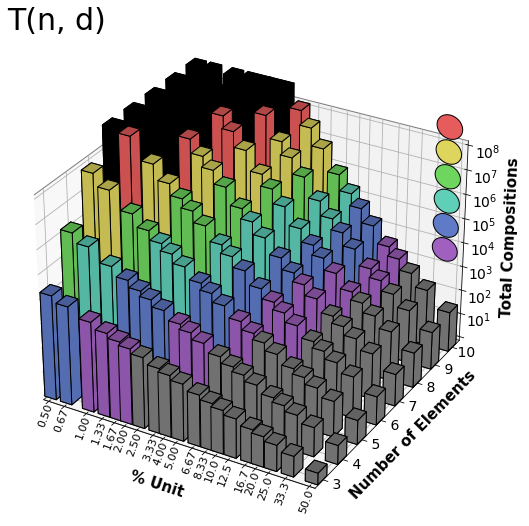

In [5]:
@timeit
def generate_bar_graph(data, y_min, y_max, x_axis_rows, colors):
    
    def select_bar_colors(dz, colors):
        conditions, choices = [], []
        conditions.extend([(dz < 3)])
        choices.extend([colors[0]])
        for i in range(3, 8 + 1):
            condition = (dz >= i) & (dz < i + 1)
            conditions.extend([condition])
            choices.extend([colors[i - 2]])

        color_list = np.select(conditions, choices, default='black')
        return color_list

    def draw_ellipses():
        scale = 0.95
        ellipse_properties, ellipses = [], []
        for i in range(1, 7):
            center = (np.log10(x_min + 0.2 * graph_range_x), i + 3 - 0.35)
            facecolor = colors[i]
            ellipse_properties.append((center, facecolor))
        for center, facecolor in ellipse_properties:
            ellipse = patches.Ellipse(xy=center,
                                      width=scale * graph_range_x / 10,
                                      height=scale * 1,
                                      edgecolor='k',
                                      facecolor=facecolor)
            ellipses.append(ellipse)
        for ellipse in ellipses:
            ax.add_patch(ellipse)
            art3d.pathpatch_2d_to_3d(ellipse, z=y_max + 0.25, zdir="y")

    y_axis_rows = range(y_min, y_max + 1)
    x_min, x_max = min(data['fraction']), max(data['fraction'])
    graph_range_y = (y_max + 0.25) - (y_min - 0.25)
    graph_range_x = (np.log10(x_max)) - (np.log10(x_min))

    xpos_calc, ypos_calc = np.meshgrid(data['fraction'], np.arange(y_max, y_min - 1, -1))
    xpos = np.log10(xpos_calc.flatten()) - 0.06
    ypos = ypos_calc.flatten() - 0.4
    zpos = np.zeros(len(data['fraction']) * len(np.arange(3, len(data.columns) + 3 - 1, 1)))
    dx = graph_range_x * (1 / 22) * np.ones_like(zpos)
    dy = graph_range_y * (3 / 50) * np.ones_like(zpos)
    dz = np.log10(np.array(data.iloc[:, 1:])[:, ::-1].flatten(order='F'))
    xticklabels = (100 / data['fraction']).apply(lambda x: f"{x:.1f}" if x >= 10 else f"{x:.2f}").tolist()
    yticklabels = ['       ' + str(num) for num in y_axis_rows]
    zticklabels = [''] + [f'$10^{i}$' for i in range(1, 9)]
    color_list = select_bar_colors(dz, colors)

    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, alpha=1.0, edgecolor='k', color=color_list)

    draw_ellipses()

    ax.tick_params(axis='x', pad=10)
    ax.tick_params(axis='y', pad=-10)
    ax.tick_params(axis='z', labelsize=14)

    ax.set_xlim(np.log10(x_max), np.log10(x_min))
    ax.set_ylim(y_min - 0.25, y_max + 0.25)
    ax.set_zlim(0, 8.0)

    ax.set_xlabel('% Unit', labelpad=8, fontsize=15, fontweight='heavy')
    ax.set_ylabel('Number of Elements', labelpad=0, fontsize=15, fontweight='heavy')
    ax.set_zlabel("Total Compositions", labelpad=8, fontsize=15, fontweight='heavy')

    ax.set_xticks(round(np.log10(data['fraction']), 3))
    ax.set_yticks(range(y_min, y_max + 1))
    ax.set_zticks(range(9))

    ax.set_xticklabels(xticklabels, fontsize=11, va='baseline', rotation=70)
    ax.set_yticklabels(yticklabels, fontsize=14)
    ax.set_zticklabels(zticklabels, fontsize=14)

    ax.xaxis.pane.set_edgecolor('black')
    ax.yaxis.pane.set_edgecolor('black')
    ax.zaxis.pane.set_edgecolor('black')

    plt.subplots_adjust(left=0.18, right=0.79, top=0.99, bottom=0.08)

    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('left')
    
    plt.title('T(n, d)',fontsize=30, loc='left')

def htmdec_colormap():
    n = 256
    s = np.linspace(0.5, 0.6, n)
    v = np.linspace(0.75, 0.9, n)
    h = np.linspace(280/360, 0/360, n)
    cmap_hsv = np.column_stack((h, s, v))
    cmap_rgb = colors.hsv_to_rgb(cmap_hsv)
    return colors.ListedColormap(cmap_rgb)

def define_colors(cmap, number_of_segments):
    segments = plt.get_cmap(cmap)(np.linspace(0, 1, number_of_segments))
    color_list = [colors.rgb2hex(segments[i]) for i in range(number_of_segments)]
    return color_list

def truncate_data(data, x_axis_rows, y_min, y_max, cutoff_point):
    y_axis_rows = range(y_min, y_max + 1)
    columns_to_keep = ['fraction'] + [f"n={n}" for n in y_axis_rows]
    df = data.loc[data['fraction'].isin(x_axis_rows), columns_to_keep].copy()
    df[df > cutoff_point] = cutoff_point
    return df

def main():
    df_select_parameters = {
        'data': composition_matrix,
        'x_axis_rows': [2, 3, 4, 5, 6, 8, 10, 12, 15, 20, 25, 30, 40, 50, 60, 75, 100, 150, 200],
        'y_min': 3,
        'y_max': 10,
        'cutoff_point': 1e9}
    
    df_select = truncate_data(**df_select_parameters)
    color_list = ['#808080'] + define_colors(cmap=htmdec_colormap(), number_of_segments=6)
    
    bar_graph_3d_parameters = {
        'data': df_select,
        'y_min': df_select_parameters['y_min'],
        'y_max': df_select_parameters['y_max'],
        'x_axis_rows': df_select_parameters['x_axis_rows'],
        'colors': color_list}

    generate_bar_graph(**bar_graph_3d_parameters)

if __name__ == "__main__":
    main()

Great, that's helpful. At a glance, we can judge the order of magnitude we're working with given a set of design parameters. At a glance, tracking the columns by eye can be a little difficult, so let's add some contrast and select specific values for a potential project.

Time elapsed for generate_bar_graph_with_highlights: 0.047 seconds


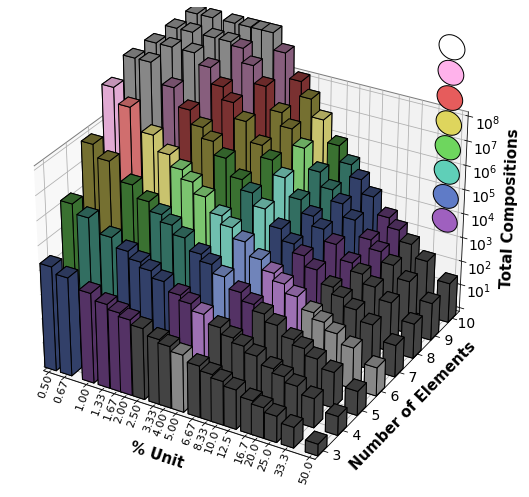

In [9]:
@timeit
def generate_bar_graph_with_highlights(data, y_min, y_max, x_axis_rows, colors, n, d):
    
    def select_bar_colors_dimmed(dz, colors, n, d):
        
        def lighten_hex_color(hex_color, lighten_factor):
            rgb_color = tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5))
            lightened_rgb = tuple(int(min(c + (255 - c) * lighten_factor, 255)) for c in rgb_color)
            lightened_hex = '#{:02x}{:02x}{:02x}'.format(*lightened_rgb)
            return lightened_hex
        def darken_hex_color(hex_color, darken_factor):
            rgb_color = tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5))
            darkened_rgb = tuple(int(c * (1 - darken_factor)) for c in rgb_color)
            darkened_hex = '#{:02x}{:02x}{:02x}'.format(*darkened_rgb)
            return darkened_hex
        
        colors_lighter = [lighten_hex_color(color, lighten_factor=0.2) for color in colors]
        colors_darker = [darken_hex_color(color, darken_factor=0.4) for color in colors]
        
        conditions, choices = [], []
        condition_xaxis = (xpos > np.log10(d) - 0.07) & (xpos < np.log10(d))
        condition_yaxis = (ypos > n - 0.5) & (ypos < n)
        conditions.extend([((dz < 3) & condition_yaxis) | ((dz < 3) & condition_xaxis),
                           (dz < 3)])
        choices.extend([colors_lighter[0],
                        colors_darker[0]])
    
        for i in range(3, 10 + 1):
            condition1 = ((dz >= i) & (dz < i+1) & condition_yaxis) | ((dz >= i) & (dz < i+1) & condition_xaxis)
            condition2 = (dz >= i) & (dz < i+1)
            conditions.extend([condition1, condition2])
            choices.extend([colors_lighter[i-2], colors_darker[i-2]])
            
        color_list = np.select(conditions, choices, default='black')
        return color_list

    def draw_ellipses():
        scale = 0.95
        ellipse_properties, ellipses = [], []
        for i in range(1, 9):
            center = (np.log10(x_min + 0.2 * graph_range_x), i + 3 - 0.35)
            facecolor = colors[i]
            ellipse_properties.append((center, facecolor))
        for center, facecolor in ellipse_properties:
            ellipse = patches.Ellipse(xy=center,
                                      width=scale * graph_range_x / 10,
                                      height=scale * 1,
                                      edgecolor='k',
                                      facecolor=facecolor)
            ellipses.append(ellipse)
        for ellipse in ellipses:
            ax.add_patch(ellipse)
            art3d.pathpatch_2d_to_3d(ellipse, z=y_max + 0.25, zdir="y")
            
    y_axis_rows = range(y_min, y_max + 1)
    x_min, x_max = min(data['fraction']), max(data['fraction'])
    graph_range_y = (y_max + 0.25) - (y_min - 0.25)
    graph_range_x = (np.log10(x_max)) - (np.log10(x_min))

    xpos_calc, ypos_calc = np.meshgrid(data['fraction'], np.arange(y_max, y_min - 1, -1))
    xpos = np.log10(xpos_calc.flatten()) - 0.06
    ypos = ypos_calc.flatten() - 0.4
    zpos = np.zeros(len(data['fraction']) * len(np.arange(3, len(data.columns) + 3 - 1, 1)))
    dx = graph_range_x * (1 / 22) * np.ones_like(zpos)
    dy = graph_range_y * (3 / 50) * np.ones_like(zpos)
    dz = np.log10(np.array(data.iloc[:, 1:])[:, ::-1].flatten(order='F'))
    xticklabels = (100 / data['fraction']).apply(lambda x: f"{x:.1f}" if x >= 10 else f"{x:.2f}").tolist()
    yticklabels = ['       ' + str(num) for num in y_axis_rows]
    zticklabels = [''] + [f'$10^{i}$' for i in range(1, 9)]
    
    color_list = select_bar_colors_dimmed(dz, colors, n, d)

    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, alpha=1.0, edgecolor='k', color=color_list)
    draw_ellipses()

    ax.tick_params(axis='x', pad=10)
    ax.tick_params(axis='y', pad=-10)
    ax.tick_params(axis='z', labelsize=14)

    ax.set_xlim(np.log10(x_max), np.log10(x_min))
    ax.set_ylim(y_min - 0.25, y_max + 0.25)
    ax.set_zlim(0, 8.0)

    ax.set_xlabel('% Unit', labelpad=8, fontsize=15, fontweight='heavy')
    ax.set_ylabel('Number of Elements', labelpad=0, fontsize=15, fontweight='heavy')
    ax.set_zlabel("Total Compositions", labelpad=8, fontsize=15, fontweight='heavy')
    
    ax.set_xticks(round(np.log10(data['fraction']), 3))
    ax.set_yticks(range(y_min, y_max + 1))
    ax.set_zticks(range(9))

    ax.set_xticklabels(xticklabels, fontsize=11, va='baseline', rotation=70)
    ax.set_yticklabels(yticklabels, fontsize=14)
    ax.set_zticklabels(zticklabels, fontsize=14)

    ax.xaxis.pane.set_edgecolor('black')
    ax.yaxis.pane.set_edgecolor('black')
    ax.zaxis.pane.set_edgecolor('black')

    plt.subplots_adjust(left=0.18, right=0.79, top=0.99, bottom=0.08)
    # plt.title(f'T(n = {n},d = {d})',fontsize=30, loc='left')
    # plt.title(f'Design Space',fontsize=36, loc='center')

    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('left')

def htmdec_colormap():
    n = 256
    s = np.linspace(0.5, 0.6, n)
    v = np.linspace(0.75, 0.9, n)
    h = np.linspace(280/360, 0/360, n)
    cmap_hsv = np.column_stack((h, s, v))
    cmap_rgb = colors.hsv_to_rgb(cmap_hsv)
    return colors.ListedColormap(cmap_rgb)

def define_colors(cmap, number_of_segments):
    segments = plt.get_cmap(cmap)(np.linspace(0, 1, number_of_segments))
    color_list = [colors.rgb2hex(segments[i]) for i in range(number_of_segments)]
    return color_list

def truncate_data(data, x_axis_rows, y_min, y_max, cutoff_point):
    y_axis_rows = range(y_min, y_max + 1)
    columns_to_keep = ['fraction'] + [f"n={n}" for n in y_axis_rows]
    df = data.loc[data['fraction'].isin(x_axis_rows), columns_to_keep].copy()
    df[df > cutoff_point] = cutoff_point
    return df

def main(parameter_n, parameter_d):
    df_select_parameters = {
        'data': composition_matrix,
        'x_axis_rows': [2, 3, 4, 5, 6, 8, 10, 12, 15, 20, 25, 30, 40, 50, 60, 75, 100, 150, 200],
        'y_min': 3,
        'y_max': 10,
        'cutoff_point': 1e10}
    
    df_select = truncate_data(**df_select_parameters)
    color_list = ['#808080'] + define_colors(cmap=htmdec_colormap(),
                                             number_of_segments=6) + ['#FFB2EB'] + ['#FFFFFF']
    
    bar_graph_3d_parameters = {
        'data': df_select,
        'y_min': df_select_parameters['y_min'],
        'y_max': df_select_parameters['y_max'],
        'x_axis_rows': df_select_parameters['x_axis_rows'],
        'colors': color_list,
        'n': parameter_n,
        'd': parameter_d}
    
    generate_bar_graph_with_highlights(**bar_graph_3d_parameters)

if __name__ == "__main__":
    parameter_n = 6
    parameter_d = 20
    main(parameter_n = parameter_n, parameter_d = parameter_d)

n = 7 and the resolution of 2.5% corresponds to d = 40. We are between 10^6 and 10^7. If you go back and select 7 and 40 for the query, you will get 9,366,812 compositions.

This visual answers some immediate project design questions. Perhaps you are considering adding another element, and would prefer to know if it's still feasible for high performance CALPHAD calculations. If you consider 10^7 (10,000,000; 10 million) to be an upper reasonable bound for your modeling times, then this would not be acceptable, given your desire to calculate a property every 2.5%. It would however, be fine at 5%.

Conversely, you can see that with that same upper bound you can not refine the resolution any more without going above the modeling limit. 2% would put you into the 10's of millions.

With this overall view of the size of the compositional space, you can see that it is not difficult to devise a project where there are too many compositions for you to model.

It's at this point where we need an algorithm that actually generates a list of compositions given our parameters.

Generating the list itself is actually not that bad.

For good measure, we've double-checked that the value is in the composition_matrix found earlier.

In [10]:
@timeit
def partitioned_answer(d, n):
    memo = {}

    def partition(d, n, depth=0):
        if (d, n, depth) in memo:
            return memo[(d, n, depth)]

        if n == depth:
            return [[]]
        partitions = [
            item + [i]
            for i in range(d + 1)
            for item in partition(d - i, n, depth=depth + 1)
        ]
        memo[(d, n, depth)] = partitions
        return partitions

    partitioned_answer = [[d - sum(p)] + p for p in partition(d, n - 1)]
    result = [[x / d for x in sublist] for sublist in partitioned_answer if d not in sublist]

    return result

def create_composition_list(n: int, d: int) -> pd.DataFrame:
    column_names = [f"element{i}" for i in range(1, parameter_n + 1)]
    composition_list = partitioned_answer(parameter_d, parameter_n)
    composition_list = [sublist + [parameter_n - sublist.count(0)] for sublist in composition_list]
    composition_list = pd.DataFrame(composition_list,
                                    columns = column_names + ['System Size']
                                    ).sort_values(['System Size'], ascending = [False])    
    return composition_list

parameter_n = 6
parameter_d = 20
composition_list = create_composition_list(n = parameter_n, d = parameter_d)

print(f'\nStart of list\n{composition_list.iloc[:15,:parameter_n]}')
print(f'\nEnd of list\n{composition_list.iloc[-15:,:parameter_n]}')

Time elapsed for partitioned_answer: 0.204 seconds

Start of list
       element1  element2  element3  element4  element5  element6
26432      0.10      0.05      0.05      0.20      0.50      0.10
14877      0.30      0.10      0.35      0.05      0.15      0.05
32522      0.10      0.05      0.10      0.10      0.50      0.15
14882      0.05      0.35      0.35      0.05      0.15      0.05
14881      0.10      0.30      0.35      0.05      0.15      0.05
14880      0.15      0.25      0.35      0.05      0.15      0.05
14879      0.20      0.20      0.35      0.05      0.15      0.05
14878      0.25      0.15      0.35      0.05      0.15      0.05
14876      0.35      0.05      0.35      0.05      0.15      0.05
14867      0.35      0.10      0.30      0.05      0.15      0.05
32523      0.05      0.10      0.10      0.10      0.50      0.15
14873      0.05      0.40      0.30      0.05      0.15      0.05
14872      0.10      0.35      0.30      0.05      0.15      0.05
14871     

For good measure, we can check that this value is in the matrix derived earlier.

In [11]:
def find_value_in_dataframe(df: pd.DataFrame, value: int) -> tuple[str, int]:
    value_found = False
    for column in df.columns:
        if value in df[column].values:
            row_index = df[df[column] == value].index[0]
            column_name, first_value = column, df.iloc[row_index][0]
            print(f'Value {value} found in column "{column_name}", with corresponding d value: {first_value}')
            value_found = True
    if value_found == True:
        return
    else:
        print(f'Value {value} not found in matrix')

def main():
    value_to_find = 50000
    find_value_in_dataframe(df = composition_matrix, value = value_to_find)
    
    value_to_find = composition_list.shape[0]
    find_value_in_dataframe(df = composition_matrix, value = value_to_find)

if __name__ == "__main__":
    main()

Value 50000 not found in matrix
Value 53124 found in column "n=6", with corresponding d value: 20


I apologize for the nested recursive function. It works well and my attempts to cleanly de-nest while keeping the memo resulted in errors.

This function essentially creates lists of 1's and 0's until their sum reaches the parameter n limit, running through every combination possible. At the end, the numbers are divided by the appropriate fraction based on d. It can be difficult to understand.

There is one problem, and that's sorting it. If you're only working in one system, for example Al-V-Cr-Fe-Co-Ni, **where all of those are nonzero**, then you don't need any sort. But if you have different possible subsystems, then you need some classification - an arbitrary number next to each one - such that you can graph it, notice trends, see which elements are relevant, etc..

This next block determines all of the possible systems, slices the df by system, gives it a number, and rebuilds the dataframe from the ground up. The result is a column you can instantly sort that keeps all of the subsystems together.

In [16]:
@timeit
def systems(df, column_names):
    system_types = [list(compress(column_names, sublist > 0)) for sublist in df[column_names].to_numpy()]
    return system_types

@timeit
def sort_dataframe_by_systems(df, system_types):
    comp1_unindexed = pd.DataFrame()
    for i, subsystem in enumerate(system_types):
        condition = (np.all(df[subsystem] > 0, axis=1)) & (np.isclose(np.sum(df[subsystem], axis=1), 1))
        current_type = i + 1
        comp1_subset = df[condition].copy()
        comp1_subset['System Type'] = comp1_subset['System Type'].where(comp1_subset['System Type'] != 0, current_type)
        comp1_unindexed = pd.concat([comp1_unindexed, comp1_subset])
    comp2 = comp1_unindexed.reset_index(drop=True)
    return comp2

def get_system_types(data: pd.DataFrame, n: int) -> list:
    composition_list['System Type'] = 0
    composition_list_unique_subset = composition_list.where(composition_list == 0, 1).drop_duplicates()
    column_names = [f"element{i}" for i in range(1, parameter_n + 1)]
    system_types = systems(composition_list_unique_subset, column_names)
    return system_types

system_types = get_system_types(composition_list, parameter_n)
composition_list_2 = sort_dataframe_by_systems(composition_list, system_types)
print(f'\nStart of list\n{composition_list_2.iloc[:15,:parameter_n+2]}')
print(f'\nEnd of list\n{composition_list_2.iloc[-15:,:parameter_n+2]}')

Time elapsed for systems: 0.000 seconds
Time elapsed for sort_dataframe_by_systems: 0.218 seconds

Start of list
    element1  element2  element3  element4  element5  element6  System Size  \
0       0.10      0.05      0.05      0.20      0.50      0.10            6   
1       0.30      0.10      0.35      0.05      0.15      0.05            6   
2       0.10      0.05      0.10      0.10      0.50      0.15            6   
3       0.05      0.35      0.35      0.05      0.15      0.05            6   
4       0.10      0.30      0.35      0.05      0.15      0.05            6   
5       0.15      0.25      0.35      0.05      0.15      0.05            6   
6       0.20      0.20      0.35      0.05      0.15      0.05            6   
7       0.25      0.15      0.35      0.05      0.15      0.05            6   
8       0.35      0.05      0.35      0.05      0.15      0.05            6   
9       0.35      0.10      0.30      0.05      0.15      0.05            6   
10      0.05      

That sounds great, until you look at time complexity.

By changing the number of alloy to sort (increasing row size):

6 columns
10^4: 0.03 sec
10^5: 0.3 sec
10^6: 3 sec

8 columns
10^4: 0.2 sec
10^5: 1.3 sec
10^6: 11.5 sec

With row size: ~ O(n)


By changing the number of elements (increasing column size):
    
10^4 rows
6: 0.03 sec
7: 0.109 sec
8: 0.22 sec
9: 0.49 sec
10: 1 sec
11: 1.9 sec
12: 3.5 sec

10^6 rows
6: 2.9 sec
7: 6.2 sec
8: 13 sec

With column size: ~ O(2^n)


So you need to be very careful about this. Grab a few million rows and 10 elements and you may want a High Performance Computing server. The good news is that most projects will not go very high in parameter_n.


composition_list_unique_subset = composition_list.where(composition_list == 0, 1).drop_duplicates().iloc[:,:-1]

list_of_lists = []
for index, row in composition_list_unique_subset.iterrows():
    sublist = [col for col in range(len(row)) if row[col] == 1]
    list_of_lists.append(sublist)

composition_list['combination'] = 0


b2 = pd.DataFrame()
for i, sublist in enumerate(list_of_lists):
    not_parameter_n = [x for x in list(range(parameter_n)) if x not in sublist]
    addition_to_df = composition_list[(composition_list.iloc[:,not_parameter_n].eq(0)).all(axis=1) & (composition_list.iloc[:,sublist] > 0).all(axis=1)]
    b2 = pd.concat([b2, addition_to_df])
    b2.loc[addition_to_df.index, 'combination'] = i + 1



The following code block changes the working directory to the one that the current python file is in, and exports the sorted composition list as a csv. Since you might be reading this file on a Jupyter Notebook, or in some other repository, default export behavior is always set to False.

In [17]:
def change_directory_to_current_py_file() -> None:
    try:
        import os
        os.chdir(os.path.split(os.path.abspath(__file__))[0])
    except Exception as e:
        print(f'\nDirectory change or os module error:\n\n{e}')

@timeit
def export_dataframe_to_csv(data: pd.DataFrame, file_name: str, save_data: bool) -> None:
    if save_data:
        with open(f'{file_name}.csv', 'w') as f:
            data.to_csv(f, line_terminator='\n')
            print(f'\nData exported to {file_name}_umap.csv')

file_name = f'composition_list_n{parameter_n}_d{parameter_d}'
save_data = False

change_directory_to_current_py_file()
export_dataframe_to_csv(data = composition_list_2, file_name = file_name, save_data = save_data)


Directory change or os module error:

name '__file__' is not defined
Time elapsed for export_dataframe_to_csv: 0.000 seconds
